# Open University Data Analysis Workshop Project

Served by:
Itay Cohen - 209146158
Alon Gilda - 209146224

## Project Goal

The goal of this project is to give us users a better way to plan their trips using public transportation.
 
Often times when we plan a trip using public transportation and we count on the timings specified by the public transportation companies, we find ourselves waiting for the bus for a long time, or even worse, missing the bus and having to wait for the next one.

This project aims to solve this problem by using real-time data to predict the arrival time of the bus to the station, and to give the user a better estimation of the arrival time of the bus to the station.

## Motivation

We both live outside of Tel Aviv and have a long commute to work.

We prefer to relay on public transportation rather than driving to work.

Current applications and methods in Israel are far from accurate. We find ourselves not trusting the applications and prefer to use our own estimations based on our personal experience.

We believe that we can use the data that is available to us to create a better estimation of the arrival time of the bus to the station.




# Data sources - overview

There is a lot of data around public transportation methods, most of it relies on government source.

These sources listed below, are what we found best to describe the data we need to create our model. 

### GTFS

GTFS is a standard format for public transportation data. It is used by many public transportation companies around the world.

In Israel, GTFS data is being published in government websites, as long with some other private archives.
 
You can find here a detailed example of what GTFS data looks like:

[https://transitfeeds.com/p/ministry-of-transport-and-road-safety/820/latest/routes](https://transitfeeds.com/p/ministry-of-transport-and-road-safety/820/latest/routes)

*GTFS Data only contains planned data, and does not contain real-time data.*

### SIRI (Real time data)

SIRI Data is the Israeli government name for it's real-time bus API.

It's being published by a specific API upon request, and gives the opportunity to log real time data.

[https://www.gov.il/he/departments/general/real_time_information_siri](https://www.gov.il/he/departments/general/real_time_information_siri)

### Hasadna - Open Bus

Hasadna is a non-profit organization, based on volunteers, that collects data from the Israeli government and publishes it to the public.


Open Bus is a project by Hasadna that collects data from the SIRI API and publishes it to the public.

They log the data into servers and allow querying it via an API called Stride.

Hasadna Site : [www.hasadna.org.il](www.hasadna.org.il)


### Install dependencies

This notebook requires two dependencies which can be installed with the following command `pip install pandas open-bus-stride-client`.


In [18]:
import pandas as pd
import math
import stride
import plotly.express as px
import seaborn as sns
import os
import datetime
from datetime import timedelta
import random
from IPython.display import display

# Data Collection

Utilize the Stride API to collect data and explain the data we collected.

The input we use is line numbers. I live close by to line 123, and Itay lives close by to line 202.

The data displayed below is the first query in order to generate the official 'line_ref' and 'operator_ref', which are a more official version of the line number.

In [19]:
# TODO ADD MORE EXPLAINATIONS on this fields
display(pd.DataFrame(stride.iterate('/gtfs_routes/list', {"route_short_name": "123", "limit": 3}, limit=3)))

,id,date,line_ref,operator_ref,route_short_name,route_long_name,route_mkt,route_direction,route_alternative,agency_name,route_type
0,997,2022-03-14,4134,3,123,ת. מרכזית חוף הכרמל/רציפים עירוני-חיפה<->ת. מר...,10123,1,#,אגד,3
1,998,2022-03-14,4135,3,123,ת. מרכזית המפרץ/רציפים עירוני-חיפה<->ת. מרכזית...,10123,2,#,אגד,3
2,1306,2022-03-14,6529,4,123,המרפא-ירושלים<->תלמוד תורה/דרך קדם-מעלה אדומים-1#,11123,1,#,אגד תעבורה,3


### Siri rides

After getting the official line name, we collect data about the rides that we're done in that day.

We'll show here a specific example for a operator ref + line ref

Each bus ride has a special ID to it.

The query needs to have a short time frame or else it will take a long time to run.

In [21]:
# TODO Add explanations on the output fields
display(pd.DataFrame(stride.iterate('/siri_rides/list', {
            "gtfs_ride__start_time_from": '2023-08-01T00:00:00+03:00',
            "scheduled_start_time_from": '2023-08-01T00:00:00+03:00',
            "gtfs_ride__start_time_to": '2023-08-02T00:00:00+03:00',
            "scheduled_start_time_to": '2023-08-02T00:00:00+03:00',
            "gtfs_route__line_refs": "4135",
            "limit": 3
        }, limit = 3)))

,id,siri_route_id,journey_ref,scheduled_start_time,vehicle_ref,updated_first_last_vehicle_locations,first_vehicle_location_id,last_vehicle_location_id,updated_duration_minutes,duration_minutes,...,gtfs_route__date,gtfs_route__line_ref,gtfs_route__operator_ref,gtfs_route__route_short_name,gtfs_route__route_long_name,gtfs_route__route_mkt,gtfs_route__route_direction,gtfs_route__route_alternative,gtfs_route__agency_name,gtfs_route__route_type
0,45186667,1851,2023-08-01-47514084,2023-08-01 01:48:00+00:00,23298702,2023-08-01 02:48:10.381392+00:00,2419652557,2419671361,2023-08-01 09:50:08.291724+00:00,38,...,2023-08-01,4135,3,123,ת. מרכזית המפרץ/רציפים עירוני-חיפה<->ת. מרכזית...,10123,2,#,אגד,3
1,45194056,1851,2023-08-01-46050026,2023-08-01 03:38:00+00:00,23316202,2023-08-01 04:51:26.668576+00:00,2419873682,2420159075,2023-08-01 12:52:54.580704+00:00,53,...,2023-08-01,4135,3,123,ת. מרכזית המפרץ/רציפים עירוני-חיפה<->ת. מרכזית...,10123,2,#,אגד,3
2,45197636,1851,2023-08-01-57498150,2023-08-01 04:02:00+00:00,7534669,2023-08-01 05:11:08.322010+00:00,2420017461,2420330647,2023-08-01 13:01:04.033183+00:00,51,...,2023-08-01,4135,3,123,ת. מרכזית המפרץ/רציפים עירוני-חיפה<->ת. מרכזית...,10123,2,#,אגד,3


### Siri ride stops

We want to create predictions per station of the ride.

We take each ride and query the stops that were made in that ride.

In [23]:
display(pd.DataFrame(stride.iterate('/siri_ride_stops/list', {
            "siri_ride_ids": "45194056",
            "siri_ride__scheduled_start_time_from": '2023-08-01T00:00:00+03:00',
            "siri_ride__scheduled_start_time_to": '2023-08-02T00:00:00+03:00',
            "limit": 3
        }, limit=3)))

,id,siri_stop_id,siri_ride_id,order,gtfs_stop_id,nearest_siri_vehicle_location_id,siri_stop__code,siri_ride__siri_route_id,siri_ride__journey_ref,siri_ride__scheduled_start_time,...,gtfs_route__date,gtfs_route__line_ref,gtfs_route__operator_ref,gtfs_route__route_short_name,gtfs_route__route_long_name,gtfs_route__route_mkt,gtfs_route__route_direction,gtfs_route__route_alternative,gtfs_route__agency_name,gtfs_route__route_type
0,1177716658,5755,45194056,33,15785704,2420159075,42656,1851,2023-08-01-46050026,2023-08-01 03:38:00+00:00,...,2023-08-01,4135,3,123,ת. מרכזית המפרץ/רציפים עירוני-חיפה<->ת. מרכזית...,10123,2,#,אגד,3
1,1177710610,3504,45194056,32,15785597,2420146796,42506,1851,2023-08-01-46050026,2023-08-01 03:38:00+00:00,...,2023-08-01,4135,3,123,ת. מרכזית המפרץ/רציפים עירוני-חיפה<->ת. מרכזית...,10123,2,#,אגד,3
2,1177704517,9292,45194056,31,15785830,2420134944,42825,1851,2023-08-01-46050026,2023-08-01 03:38:00+00:00,...,2023-08-01,4135,3,123,ת. מרכזית המפרץ/רציפים עירוני-חיפה<->ת. מרכזית...,10123,2,#,אגד,3


### DataFetcher class - finalized data collection

In [26]:

lines = [123, 202, 921, 970, 148, 55, 82, 17, 18, 138, 70]
TIME_PERIOD_TRAIN = {
    'start': '2022-06-01T00:00:00+03:00',
    'end': '2022-07-01T00:00:00+03:00'
}

TIME_PERIOD_TEST = {
    'start': '2023-06-01T00:00:00+03:00',
    'end': '2023-07-01T00:00:00+03:00'
}


In [74]:
import stride
import pandas as pd
import os
import datetime
from datetime import timedelta
import random

DATA_DIR = "data"
class DataFetcher(object):
    def __init__(self,
                 name,
                 lines,
                 start_date,
                 end_date,
                 time_period_per_sample_hop_in_days = 1,
                 amount_of_lines_to_sample_per_hop = 5,
                 limit_ratio_lines_to_gtfs_lines = 5,
                 amount_of_rides_to_sample_per_hop = 100,
                 limit_routes_per_single_day = 10000,
                 limit_stops_per_single_day = 100000
                 ):
        self.start_date = start_date
        self.end_date = end_date
        self.time_period_per_sample_hop_in_days = time_period_per_sample_hop_in_days
        self.amount_of_lines_to_sample_per_hop = amount_of_lines_to_sample_per_hop
        self.limit_ratio_lines_to_gtfs_lines = limit_ratio_lines_to_gtfs_lines
        self.limit_routes_per_single_day = limit_routes_per_single_day
        self.limit_stops_per_single_day = limit_stops_per_single_day
        self.amount_of_rides_to_sample_per_hop = amount_of_rides_to_sample_per_hop
        self.lines = lines
        self.id = f"{name}_{start_date}_{end_date}"

    def fetch(self):
        # Check if data already exists
        final_data_path = f"{DATA_DIR}/{self.id}_final_data.csv"
        if os.path.exists(final_data_path):
            return pd.read_csv(final_data_path)

        # Fetch data
        self.data = self.fetch_loop()
        # Save data
        self.cache_table(self.data, "final_data")
        return self.data


    def get_time_periods(self):
        time_periods = []
        # Time example - 2023-08-01T00:00:00+03:00
        start_time_as_datetime = datetime.datetime.strptime(self.start_date, "%Y-%m-%dT%H:%M:%S%z")
        end_time_as_datetime = datetime.datetime.strptime(self.end_date, "%Y-%m-%dT%H:%M:%S%z")

        current_time = start_time_as_datetime
        while current_time < end_time_as_datetime:
            current_time_as_str = current_time.strftime("%Y-%m-%dT%H:%M:%S%z")
            next_time = current_time + timedelta(days=self.time_period_per_sample_hop_in_days)
            next_time_as_str = next_time.strftime("%Y-%m-%dT%H:%M:%S%z")
            time_periods.append((current_time_as_str, next_time_as_str))
            current_time = next_time

        return time_periods
    def fetch_loop(self):
        # One time convert lines to gtfs lines
        self.gtfs_lines = self.convert_lines_to_gtfs_lines()
        self.lines_refs_unq = self.gtfs_lines['line_ref'].unique()

        full_siri_ride_stops = pd.DataFrame()
        for start_time_as_str, end_time_as_str in self.get_time_periods():
            print(f"Fetching data for time period: {start_time_as_str} - {end_time_as_str}")
            siri_ride_stops_daily = self.fetch_single_time_period(start_time_as_str, end_time_as_str)
            if siri_ride_stops_daily is None or siri_ride_stops_daily.empty:
                continue
            full_siri_ride_stops = pd.concat([full_siri_ride_stops, siri_ride_stops_daily])

        return full_siri_ride_stops

    def fetch_single_time_period(self, start_time_str, end_time_str):
        # Randomly select lines refs to sample
        sampled_line_refs = random.sample(list(self.lines_refs_unq), self.amount_of_lines_to_sample_per_hop)
        print(f"Sampled line refs: {sampled_line_refs}")
        # Get rides for those lines
        siri_rides = self.read_siri_rides(sampled_line_refs, start_time_str, end_time_str)
        # return if siri rides is empty
        if siri_rides.empty:
            return pd.DataFrame()
        siri_ride_ids_unq = siri_rides['id'].unique()
        # Get stops for those rides
        siri_ride_stops = self.read_siri_ride_stops(siri_ride_ids_unq, start_time_str, end_time_str)
        return siri_ride_stops

    def convert_lines_to_gtfs_lines(self):
        cached_data = self.read_cached_table("lines_data")
        if cached_data is not None:
            return cached_data

        lines_data = pd.DataFrame()

        # Iterate each line and append to the lines_data dataframe
        for line in self.lines:
            new_line_by_short_name = pd.DataFrame(
                stride.iterate('/gtfs_routes/list', {"route_short_name": line, "limit": 5}, limit=5))

            lines_data = pd.concat([lines_data, new_line_by_short_name])

        self.cache_table(lines_data, "lines_data")
        return lines_data

    def read_siri_rides(self, line_refs_unq, start_time_str, end_time_str):
        table_name = f"siri_rides_{start_time_str}_{end_time_str}"
        cached_data = self.read_cached_table(table_name)
        if cached_data is not None:
            return cached_data

        # Get GTFS Data
        siri_rides = pd.DataFrame(stride.iterate('/siri_rides/list', {
            "gtfs_ride__start_time_from": start_time_str,
            "scheduled_start_time_from": start_time_str,
            "gtfs_ride__start_time_to": end_time_str,
            "scheduled_start_time_to": end_time_str,
            "gtfs_route__line_refs": ",".join([str(line_ref) for line_ref in line_refs_unq]),
            "limit": self.limit_routes_per_single_day
        }, limit = self.limit_routes_per_single_day))

        self.cache_table(siri_rides, table_name)
        return siri_rides

    def read_siri_ride_stops(self, siri_ride_ids_unq, start_time_str, end_time_str):
        table_name = f"siri_ride_stops_{start_time_str}_{end_time_str}"
        cached_data = self.read_cached_table(table_name)
        if cached_data is not None:
            return cached_data

        # Randomly sample rids ids
        if len(siri_ride_ids_unq) > self.amount_of_rides_to_sample_per_hop:
            print(f"Sampling {self.amount_of_rides_to_sample_per_hop} rides out of {len(siri_ride_ids_unq)}")
            siri_ride_ids_unq = random.sample(list(siri_ride_ids_unq), self.amount_of_rides_to_sample_per_hop)

        # Get GTFS Data
        siri_ride_stops = pd.DataFrame(stride.iterate('/siri_ride_stops/list', {
            "siri_ride_ids": ",".join([str(siri_ride_id) for siri_ride_id in siri_ride_ids_unq]),
            "siri_ride__scheduled_start_time_from": start_time_str,
            "siri_ride__scheduled_start_time_to": end_time_str,
            "limit": self.limit_stops_per_single_day
        }, limit=self.limit_stops_per_single_day))

        self.cache_table(siri_ride_stops, table_name)
        return siri_ride_stops

    def cache_table(self, table, table_name):
        table.to_csv(f"{DATA_DIR}/{self.id}_{table_name}.csv")

    def read_cached_table(self, table_name):
        path = f"{DATA_DIR}/{self.id}_{table_name}.csv"
        # Check if file exists
        if not os.path.exists(path):
            return None
        table = pd.read_csv(path)
        # remove unnamed column
        table = table.loc[:, ~table.columns.str.contains('^Unnamed')]
        return table

In [28]:
data_test = DataFetcher(
    name = "single_month_prod_test_set",
    lines = lines,
    start_date = TIME_PERIOD_TEST['start'],
    end_date = TIME_PERIOD_TEST['end'],
    time_period_per_sample_hop_in_days = 1,
    amount_of_lines_to_sample_per_hop = 10,
    limit_ratio_lines_to_gtfs_lines = 5,
    amount_of_rides_to_sample_per_hop = 100,
    limit_routes_per_single_day = 1000,
    limit_stops_per_single_day = 10000
)

In [29]:
test_data = data_test.fetch()

In [75]:
train_data = DataFetcher(
    name = "single_month_prod_train_set_half_day",
    lines = lines,
    start_date = TIME_PERIOD_TRAIN['start'],
    end_date = TIME_PERIOD_TRAIN['end'],
    time_period_per_sample_hop_in_days = 0.5,
    amount_of_lines_to_sample_per_hop = 10,
    limit_ratio_lines_to_gtfs_lines = 5,
    amount_of_rides_to_sample_per_hop = 100,
    limit_routes_per_single_day = 1000,
    limit_stops_per_single_day = 10000
)

In [76]:
training_data = train_data.fetch()

# EDA - Exploratory Data Analysis

In this section we will work with our main training set to get a good understanding of the data.

The purpose of this section is to:
 
1. Get a better understanding of the data we are working with
2. Explore ideas for features
3. Data cleaning methods

In [109]:
data = training_data

In [110]:
# Calculating the percentage of missing values in each column
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Displaying columns with missing values and their corresponding percentages
missing_data_summary = pd.DataFrame({'Column': missing_percentage.index, 'MissingPercentage': missing_percentage.values})
missing_data_summary = missing_data_summary[missing_data_summary.MissingPercentage > 0]
missing_data_summary.sort_values(by='MissingPercentage', ascending=False)


,Column,MissingPercentage
16,siri_ride__journey_gtfs_ride_id,75.358410
42,gtfs_ride_stop__shape_dist_traveled,14.305463
41,gtfs_ride_stop__drop_off_type,12.664946
40,gtfs_ride_stop__pickup_type,12.664946
39,gtfs_ride_stop__stop_sequence,12.664946
38,gtfs_ride_stop__departure_time,12.664946
37,gtfs_ride_stop__arrival_time,12.664946
36,gtfs_ride_stop__gtfs_ride_id,12.664946
35,gtfs_ride_stop__gtfs_stop_id,12.664946
34,nearest_siri_vehicle_location__distance_from_s...,10.407664


Our target variable is the difference between the actual arrival time and the scheduled arrival time.

This is why we need to filter our nulls for the nearest_siri_vehicle_location__siri_ride_stop_id and gtfs_ride_stop__arrival_time.

This is obviously an estimate since the exact arrival time is based on the SIRI measurements, which are being queried every other minute, approximately, according the Hasadna. 

In [111]:
data = data[data.nearest_siri_vehicle_location__siri_ride_stop_id.notnull() & data.gtfs_ride_stop__arrival_time.notnull()]

In [112]:
# Calculating the percentage of missing values in each column
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Displaying columns with missing values and their corresponding percentages
missing_data_summary = pd.DataFrame({'Column': missing_percentage.index, 'MissingPercentage': missing_percentage.values})
missing_data_summary = missing_data_summary[missing_data_summary.MissingPercentage > 0]
missing_data_summary.sort_values(by='MissingPercentage', ascending=False)

,Column,MissingPercentage
16,siri_ride__journey_gtfs_ride_id,74.624696
42,gtfs_ride_stop__shape_dist_traveled,1.757520
17,siri_ride__route_gtfs_ride_id,0.029958


Great! a lot less nulls.
Let's remove the siri_ride__journey_gtfs_ride_id column from our data, as it is not relevant and has a high null percentage.
The column 

In [113]:
data = data.drop(columns=['siri_ride__journey_gtfs_ride_id'])

In [114]:
# Correlations between columns
corr = data.corr()

In [116]:
# Calculating correlation matrix
corr_matrix = data.corr()

# Finding pairs of columns where correlation is exactly 1
correlated_pairs = corr_matrix.unstack().reset_index()
correlated_pairs.columns = ['Column1', 'Column2', 'Correlation']
correlated_pairs = correlated_pairs[correlated_pairs['Column1'] != correlated_pairs['Column2']]  # Exclude same column pairs
correlated_pairs = correlated_pairs[correlated_pairs['Correlation'] >= 0.995]

# Creating a dictionary to map the removed columns to the ones that replaced them
replacement_dict = dict(zip(correlated_pairs['Column2'], correlated_pairs['Column1']))

# Extracting columns to remove (keeping one from each pair)
columns_to_remove = correlated_pairs['Column2'].unique()

# Removing the columns
data = data.drop(columns=columns_to_remove)

for column_removed, replaced_with in replacement_dict.items():
    print(f"Removed column: {column_removed}, replaced with: {replaced_with}")


Removed column: siri_ride_id, replaced with: gtfs_ride__gtfs_route_id
Removed column: gtfs_stop_id, replaced with: gtfs_ride__gtfs_route_id
Removed column: nearest_siri_vehicle_location_id, replaced with: gtfs_ride__gtfs_route_id
Removed column: siri_ride__first_vehicle_location_id, replaced with: gtfs_ride__gtfs_route_id
Removed column: siri_ride__last_vehicle_location_id, replaced with: gtfs_ride__gtfs_route_id
Removed column: siri_ride__route_gtfs_ride_id, replaced with: gtfs_ride__gtfs_route_id
Removed column: siri_ride__gtfs_ride_id, replaced with: gtfs_ride__gtfs_route_id
Removed column: nearest_siri_vehicle_location__siri_snapshot_id, replaced with: gtfs_ride__gtfs_route_id
Removed column: nearest_siri_vehicle_location__siri_ride_stop_id, replaced with: gtfs_ride__gtfs_route_id
Removed column: gtfs_ride_stop__gtfs_stop_id, replaced with: gtfs_ride__gtfs_route_id
Removed column: gtfs_ride_stop__gtfs_ride_id, replaced with: gtfs_ride__gtfs_route_id
Removed column: gtfs_ride__gtfs_

In [ ]:
data

<AxesSubplot:>

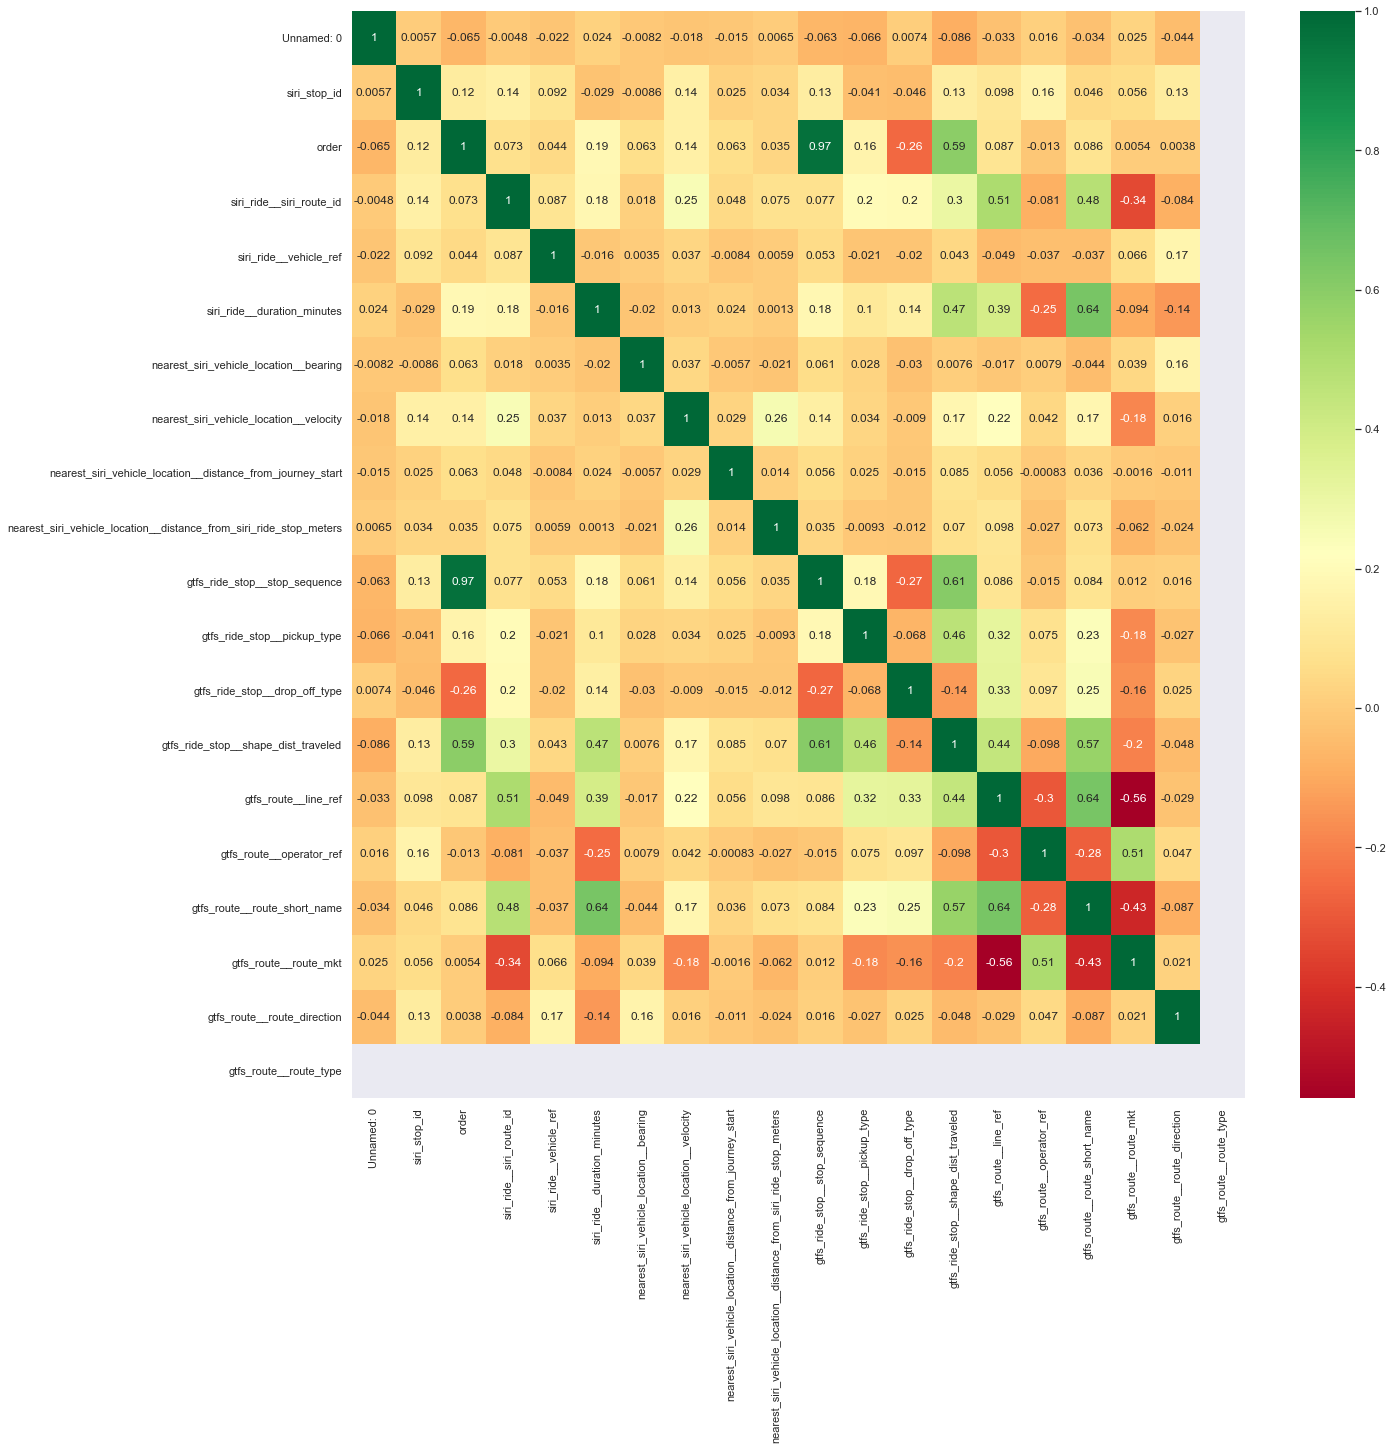

In [117]:
corr = data.corr()

# Plot a big heatmap of the correlations
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(corr, annot=True, cmap="RdYlGn")


In [ ]:
# Convert wanted columns to datetime
data['4.5'] = pd.to_datetime(data['gtfs_ride_stop__arrival_time'])


In [32]:
# TODO

### FeatureCreator - finalized feature creation

# Final sets creation

# Models trainings

In this section we will train our models and evaluate them.

In [7]:
Models = [] # TODO

# Models evaluation and comparison

In [9]:
# TODO

# Summary and conclusions

In [10]:
# TODO